In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
__file__ = './'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# os.path.dirname(__file__)获取当前文件的绝对路径
# os.path.join(xx,'..')在后面追加..，相当于进入上一级目录
# os.path.abspath(xx)获取绝对路径
# sys.path.append()将其加入系统路径当中

import MSA
import LINK

In [17]:
# read data
my_link = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='demand_info')
print(my_demand)


# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 1 # path 
theta_2 = 0.5 # mode
miu_in = 25
miu_out = 30
lamda_0_hailing = 2 #2 RMB/minute
lamda_0_PR = 20 # RMB
lamda_0_transit = 5
N_hailing = 500
lamda_0_auto = LINK.compute_lamda_0_auto(fuel_consumption=8.5)

df = []
demand_level = np.arange(0.5, 3.2, 0.2) 
demand_list = demand_level * 1000
for demand in demand_list:
    my_demand['demand'] = demand
    result = MSA.assignment(my_link= my_link, my_node= my_node, my_demand= my_demand,
                        origin_zone= origin_zone, destination_zone= destination_zone,
                        miu_in= miu_in, miu_out= miu_out,
                        lamda_0_auto= lamda_0_auto,
                        lamda_0_hailing= lamda_0_hailing,
                        lamda_0_transit= lamda_0_transit,
                        lamda_0_PR= lamda_0_PR,
                        theta_1= theta_1, theta_2= theta_2,
                        N_hailing= N_hailing, A=2, maximum_iter=300)
    df.append(result)

# system cost
total_cost = []
for item in df:
    flow_set = item[2].tail(item[6])
    cost = sum(abs(flow_set['path_cost']) * flow_set['path_flow'])
    total_cost.append(cost)

# OD cost
def od_cost(path, od):
    cost = sum(abs(path[path['OD_pair'] == od]['path_cost']) * path[path['OD_pair'] == od]['path_flow'])
    return cost

od_1_cost = []
od_2_cost = []
od_3_cost = []
od_4_cost = []
for i in range(len(df)):
    flow_set = df[i][2].tail(df[i][6])
    od_1_cost.append(od_cost(flow_set, 'r1-s1'))
    od_2_cost.append(od_cost(flow_set, 'r1-s2'))
    od_3_cost.append(od_cost(flow_set, 'r2-s1'))
    od_4_cost.append(od_cost(flow_set, 'r2-s2'))

# mode share
PR_logit = [df[i][4].tail(df[i][7]).iloc[0]['mode_logit'] for i in range(len(df))]
RT_logit = [df[i][4].tail(df[i][7]).iloc[1]['mode_logit'] for i in range(len(df))]
auto_logit = [df[i][4].tail(df[i][7]).iloc[2]['mode_logit'] for i in range(len(df))]
bus_logit = [df[i][4].tail(df[i][7]).iloc[3]['mode_logit'] for i in range(len(df))]

# path_flow
path_1_flow = [df[i][2].tail(df[i][6]).iloc[0]['path_flow'] for i in range(len(df))]
path_2_flow = [df[i][2].tail(df[i][6]).iloc[1]['path_flow'] for i in range(len(df))]
path_3_flow = [df[i][2].tail(df[i][6]).iloc[2]['path_flow'] for i in range(len(df))]
path_4_flow = [df[i][2].tail(df[i][6]).iloc[3]['path_flow'] for i in range(len(df))]

# path_duration
path_1_duration = [df[i][2].tail(df[i][6]).iloc[0]['path_duration'] for i in range(len(df))]
path_2_duration = [df[i][2].tail(df[i][6]).iloc[1]['path_duration'] for i in range(len(df))]
path_3_duration = [df[i][2].tail(df[i][6]).iloc[2]['path_duration'] for i in range(len(df))]
path_4_duration = [df[i][2].tail(df[i][6]).iloc[3]['path_duration'] for i in range(len(df))]

# path_cost
path_1_cost = [abs(df[i][2].tail(df[i][6]).iloc[0]['path_cost']) for i in range(len(df))]
path_2_cost = [abs(df[i][2].tail(df[i][6]).iloc[1]['path_cost']) for i in range(len(df))]
path_3_cost = [abs(df[i][2].tail(df[i][6]).iloc[2]['path_cost']) for i in range(len(df))]
path_4_cost = [abs(df[i][2].tail(df[i][6]).iloc[3]['path_cost']) for i in range(len(df))]

# ride-hailing vehicle number
n_idle = [df[i][5].tail(1).iloc[0]['n_idle'] for i in range(len(df))]
waiting_hailing = [df[i][5].tail(1).iloc[0]['wait_time'] for i in range(len(df))]

# convert to dataframe
dfx = pd.DataFrame({
        'demand': demand_level,
        'n_idle': n_idle,
        'waiting time': waiting_hailing,
        'total_cost': total_cost,
        'auto_logit': auto_logit,
        'bus_logit': bus_logit,
        'PR_logit': PR_logit,
        'RT_logit': RT_logit,
        'path_1_flow': path_1_flow,
        'path_2_flow': path_2_flow,
        'path_3_flow': path_3_flow,
        'path_4_flow': path_4_flow,
        'path_1_cost': path_1_cost,
        'path_2_cost': path_2_cost,
        'path_3_cost': path_3_cost,
        'path_4_cost': path_4_cost,
        'path_1_duration': path_1_duration,
        'path_2_duration': path_2_duration,
        'path_3_duration': path_3_duration,
        'path_4_duration': path_4_duration,})

  OD_pair  demand
0   r1-s1    1000
0.6517
['path-1', 'path-2', 'path-3', 'path-4']
['auto', 'P&R', 'transit', 'R&T']
Iteration = 1, gap = 0.6701855921901394,
the number of idle_hailing:500.0
Iteration = 2, gap = 3.0420878231138704,
the number of idle_hailing:452.11820237528815
Iteration = 3, gap = 1.518811678625121,
the number of idle_hailing:451.65487361585497
Iteration = 4, gap = 1.0111898715626124,
the number of idle_hailing:451.6800267423996
Iteration = 5, gap = 0.7577114441583694,
the number of idle_hailing:451.6987646743436
Iteration = 6, gap = 0.605762808812967,
the number of idle_hailing:451.7113174190437
Iteration = 7, gap = 0.5045325673550831,
the number of idle_hailing:451.72029527646737
Iteration = 8, gap = 0.4322644052165996,
the number of idle_hailing:451.72703686500887
Iteration = 9, gap = 0.37808766378807507,
the number of idle_hailing:451.73228635340865
Iteration = 10, gap = 0.33596640341164913,
the number of idle_hailing:451.7364904481509
Iteration = 11, gap = 0.3022

In [20]:
dfx

,demand,n_idle,waiting time,total_cost,auto_logit,bus_logit,PR_logit,RT_logit,path_1_flow,path_2_flow,path_3_flow,path_4_flow,path_1_cost,path_2_cost,path_3_cost,path_4_cost,path_1_duration,path_2_duration,path_3_duration,path_4_duration
0,0.5,451.773436,5.392056,3.514587e+04,0.252342,0.258572,0.241693,0.247393,126.170829,120.858741,129.270578,123.699852,64.212280,91.610267,50.673876,76.165094,20.927186,73.092266,102.331588,78.774958
1,0.7,431.890992,5.509139,5.379930e+04,0.251603,0.259198,0.240857,0.248342,176.130226,168.610657,181.431375,173.827742,72.161371,101.681101,54.984342,80.361757,23.517845,85.004866,112.676707,88.823531
2,0.9,411.225236,5.639445,8.111151e+04,0.249587,0.260656,0.239385,0.250371,224.638024,215.456940,234.583085,225.321952,90.008075,122.449910,62.724867,87.853818,29.334198,107.285420,131.253967,106.778418
3,1.1,389.527918,5.786908,1.241752e+05,0.246295,0.262719,0.237651,0.253334,270.934544,261.425657,288.985468,278.654330,122.506457,158.707281,75.069378,99.764565,39.925625,143.854319,160.880794,135.334717
4,1.3,366.957526,5.953522,1.929250e+05,0.242624,0.264463,0.236554,0.256359,315.422492,307.525755,343.800197,333.251556,175.411346,216.190680,93.203033,117.235416,57.167661,198.993844,204.401565,177.231438
5,1.5,344.193274,6.137339,3.026849e+05,0.240069,0.264712,0.237010,0.258208,360.117304,355.508335,397.073860,387.300502,258.770357,303.726440,118.006513,141.137559,84.334887,277.469457,263.929918,234.559818
6,1.7,322.086788,6.333531,4.789592e+05,0.239978,0.262843,0.239128,0.258051,407.964769,406.502674,446.846014,438.686544,391.090352,435.731519,149.762674,171.788445,127.458806,384.766887,340.144704,308.082705
7,1.9,300.814831,6.541643,7.597644e+05,0.242137,0.259518,0.242049,0.256297,460.050045,459.877188,493.100078,486.972690,597.158816,630.772843,188.620863,209.363890,194.617815,527.445269,433.404357,398.222150
8,2.1,279.600467,6.771528,1.189577e+06,0.244824,0.256151,0.244822,0.254203,514.114350,514.111224,537.936882,533.837544,897.467493,905.283376,235.579614,254.820382,292.490302,712.963735,546.105360,507.271753
9,2.3,257.649166,7.037523,1.815539e+06,0.246976,0.253544,0.246976,0.252504,568.030877,568.031115,583.167705,580.770303,1307.348464,1272.534063,292.072053,309.517095,426.073089,948.563883,681.687213,638.490665


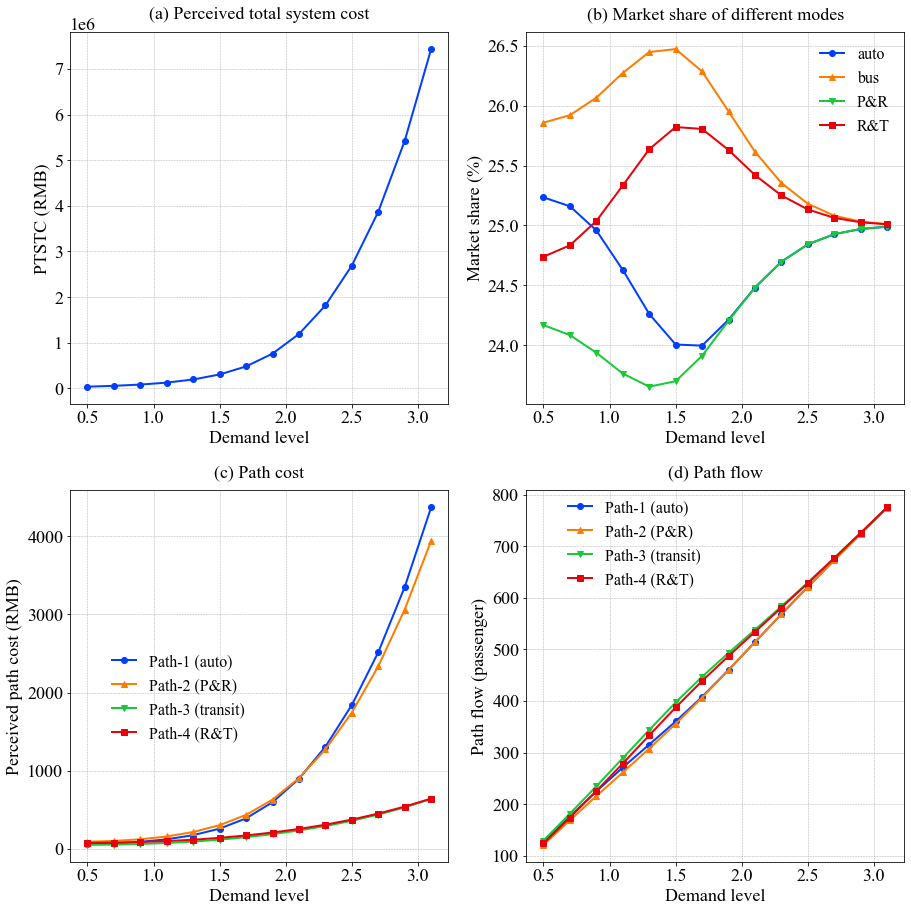

In [21]:
import seaborn as sns
sns.set_palette("bright", 10)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(13,13))
markers = ['o','^','v','s','h','D','p','<','>']

ax = plt.subplot(2,2,1)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['demand'], dfx['total_cost'], '-', lw=2, marker='o')
ax.set_xlabel('Demand level')
ax.set_ylabel('PTSTC (RMB)')
ax.set_title('(a) Perceived total system cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,2)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['demand'], dfx['auto_logit']*100, '-', lw=2, marker=markers[0], label='auto')
ax.plot(dfx['demand'], dfx['bus_logit']*100, '-', lw=2, marker=markers[1], label='bus')
ax.plot(dfx['demand'], dfx['PR_logit']*100, '-', lw=2, marker=markers[2], label='P&R')
ax.plot(dfx['demand'], dfx['RT_logit']*100, '-', lw=2, marker=markers[3], label='R&T')
ax.set_xlabel('Demand level')
ax.set_ylabel('Market share (%)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5) #, bbox_to_anchor=(0.7,0.7)
ax.set_title('(b) Market share of different modes', fontsize=18, loc='center', y=1.02,)

ax = plt.subplot(2,2,3)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['demand'], dfx['path_1_cost'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['demand'], dfx['path_2_cost'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['demand'], dfx['path_3_cost'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['demand'], dfx['path_4_cost'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Demand level')
ax.set_ylabel('Perceived path cost (RMB)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5,bbox_to_anchor = (0.5,0.6)) #,bbox_to_anchor = (0.6,0.4)
ax.set_title('(c) Path cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,4)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['demand'], dfx['path_1_flow'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['demand'], dfx['path_2_flow'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['demand'], dfx['path_3_flow'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['demand'], dfx['path_4_flow'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Demand level')
ax.set_ylabel('Path flow (passenger)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor = (0.5,0.7),)  
ax.set_title('(d) Path flow', fontsize=18, loc='center', y=1.02)

plt.tight_layout()
plt.show()

In [23]:
df[0][2]

,OD_pair,demand,path_id,name_sque,attribute_set,path_length,path_duration,path_cost,mode,mode_logit,mode_flow,path_logit,y_flow,I,path_flow
0,r1-s1,500.0,path-1,"[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]",20.0,0.000000,-0.000000,auto,0.252322,126.160795,1.0,126.160795,0,125.000000
1,r1-s1,500.0,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",21.8,0.000000,-5.000000,P&R,0.249226,124.613068,1.0,124.613068,0,125.000000
2,r1-s1,500.0,path-3,"[r1-N4, N4-N5, N5-N6, N6-s1]","[board_transit, transit, alight_transit]",22.0,0.000000,-5.000000,transit,0.249226,124.613068,1.0,124.613068,0,125.000000
3,r1-s1,500.0,path-4,"[r1-N7, N7-N8, N8-N5, N5-N6, N6-s1]","[board_ride-hailing, ride-hailing, R&T, transi...",21.0,0.000000,-5.000000,R&T,0.249226,124.613068,1.0,124.613068,0,125.000000
4,r1-s1,500.0,path-1,"[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]",20.0,20.969881,-64.343284,auto,0.252246,126.122803,1.0,126.122803,1,126.160795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,r1-s1,500.0,path-4,"[r1-N7, N7-N8, N8-N5, N5-N6, N6-s1]","[board_ride-hailing, ride-hailing, R&T, transi...",21.0,77.600347,-75.577680,R&T,0.247567,123.783584,1.0,123.783584,298,123.786606
1196,r1-s1,500.0,path-1,"[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]",20.0,20.926338,-64.209679,auto,0.252285,126.142301,1.0,126.142301,299,126.142074
1197,r1-s1,500.0,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",21.8,73.092924,-91.608868,P&R,0.241637,120.818459,1.0,120.818459,299,120.830948
1198,r1-s1,500.0,path-3,"[r1-N4, N4-N5, N5-N6, N6-s1]","[board_transit, transit, alight_transit]",22.0,102.332732,-50.674352,transit,0.258511,129.255657,1.0,129.255657,299,129.240382


In [24]:
# read data
my_link = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='demand_info')
print(my_demand)

# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 1 # path 
theta_2 = 0.5 # mode
miu_in = 25
miu_out = 30
lamda_0_hailing = 2 #2 RMB/minute
lamda_0_PR = 20 # RMB
lamda_0_transit = 5
N_hailing = 800
lamda_0_auto = LINK.compute_lamda_0_auto(fuel_consumption=8.5)

coeff_demand = np.arange(0.5, 2.1, 0.1)
dfx = []
for coefficient in coeff_demand:
    my_demand['demand'] = my_demand['demand'] *coefficient
    df = MSA.assignment(my_link= my_link, my_node= my_node, my_demand= my_demand,
                        origin_zone= origin_zone, destination_zone= destination_zone,
                        miu_in= miu_in, miu_out= miu_out,
                        lamda_0_auto= lamda_0_auto,
                        lamda_0_hailing= lamda_0_hailing,
                        lamda_0_transit= lamda_0_transit,
                        lamda_0_PR= lamda_0_PR,
                        theta_1= theta_1, theta_2= theta_2,
                        N_hailing= N_hailing, A=2, maximum_iter=300)
    
    #################################################################
    demand_level = coefficient
    n_idle = df[5].tail(1).iloc[0]['n_idle']
    waiting_hailing = df[5].tail(1).iloc[0]['wait_time']

    # mode share
    PR_logit = df[4].tail(df[7]).iloc[0]['mode_logit']
    RT_logit = df[4].tail(df[7]).iloc[1]['mode_logit']
    auto_logit = df[4].tail(df[7]).iloc[2]['mode_logit']
    bus_logit = df[4].tail(df[7]).iloc[3]['mode_logit']

    # path_duration
    path_1_duration = df[2].tail(df[6]).iloc[0]['path_duration'] 
    path_2_duration = df[2].tail(df[6]).iloc[1]['path_duration']
    path_3_duration = df[2].tail(df[6]).iloc[2]['path_duration']
    path_4_duration = df[2].tail(df[6]).iloc[3]['path_duration']

    # path_flow
    path_1_flow = df[2].tail(df[6]).iloc[0]['path_flow'] 
    path_2_flow = df[2].tail(df[6]).iloc[1]['path_flow']
    path_3_flow = df[2].tail(df[6]).iloc[2]['path_flow']
    path_4_flow = df[2].tail(df[6]).iloc[3]['path_flow']

    # path_cost
    path_1_cost = df[2].tail(df[6]).iloc[0]['path_cost'] 
    path_2_cost = df[2].tail(df[6]).iloc[1]['path_cost']
    path_3_cost = df[2].tail(df[6]).iloc[2]['path_cost']
    path_4_cost = df[2].tail(df[6]).iloc[3]['path_cost']

    # total cost
    flow_set = df[2].tail(df[6])
    cost = sum(abs(flow_set['path_cost']) * flow_set['path_flow'])

    dfx.append([demand_level, n_idle, waiting_hailing, cost,
                PR_logit, RT_logit, auto_logit, bus_logit,
                path_1_duration, path_2_duration, path_3_duration, path_4_duration,
                path_1_flow, path_2_flow, path_3_flow, path_4_flow,
                path_1_cost, path_2_cost, path_3_cost, path_4_cost])

  OD_pair  demand
0   r1-s1    1000
0.6517
['path-1', 'path-2', 'path-3', 'path-4']
['auto', 'P&R', 'transit', 'R&T']
Iteration = 1, gap = 0.6701855921901394,
the number of idle_hailing:800.0
Iteration = 2, gap = 3.0343146309526863,
the number of idle_hailing:754.2543539456685
Iteration = 3, gap = 1.5136464765506639,
the number of idle_hailing:754.0615493946933
Iteration = 4, gap = 1.007681798684463,
the number of idle_hailing:754.0865434203511
Iteration = 5, gap = 0.7550579398777058,
the number of idle_hailing:754.1023988623878
Iteration = 6, gap = 0.6036268249587992,
the number of idle_hailing:754.1130016231398
Iteration = 7, gap = 0.5027438585238125,
the number of idle_hailing:754.1205920271567
Iteration = 8, gap = 0.4307250296583706,
the number of idle_hailing:754.1262959152155
Iteration = 9, gap = 0.3767360827676042,
the number of idle_hailing:754.1307398700992
Iteration = 10, gap = 0.3347614117877356,
the number of idle_hailing:754.1343004542281
Iteration = 11, gap = 0.3011933579

In [ ]:
n_idle = df[5].tail(1).iloc[0]['n_idle']

In [ ]:
dfx

[[0.5,
  754.165668157507,
  4.216136453553259,
  35073.40476653207,
  0.2416369173139754,
  0.24756716820957644,
  0.25228460145414805,
  0.2585113130223,
  20.92633830635132,
  73.0929243651889,
  102.33273162981176,
  77.60034712992172,
  126.14207391819792,
  120.83094806937027,
  129.2403819477802,
  123.78659606465149,
  -64.20967891459817,
  -91.60886750314464,
  -50.674352464802524,
  -75.57767981812063],
 [0.6,
  772.5851927813612,
  4.167329856907815,
  20301.06077501054,
  0.24194792116489972,
  0.2473071210666115,
  0.25234249195674197,
  0.2584024658117468,
  20.120289061326062,
  68.03081385818007,
  97.70358682360384,
  73.10607301932241,
  75.70028532882564,
  72.57105650661049,
  77.52539098181079,
  74.20326718275307,
  -61.73642427947084,
  -87.91002999986173,
  -48.74554212888256,
  -73.7009983889838],
 [0.7,
  780.8125151497396,
  4.1460769811966935,
  14131.49913836576,
  0.2419896280362345,
  0.24729035180051118,
  0.2523080848866644,
  0.25841193527658995,
  20.